# Corrupted MNIST dataset

In [1]:
import os
import jax
import optax
import dojax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from time import time
from augly import image
from multiprocessing import Pool

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

In [2]:
cpu_count = os.cpu_count()
print(f"Number of cores: {cpu_count}")

Number of cores: 96


In [3]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [93]:
class Corrupt:
    def __init__(self, p):
        """
        Class to corrupt an image. Each pixel is given a
        random value with probability p
        """
        self.p = p
        
    def __call__(self, imgs):
        return self.transform_multiple(imgs)

    def transform(self, img):
        """
        Corrup an image with noise

        Paramters
        ---------
        X: np.array
            A single NxM-dimensional array
        """
        img_size = img.shape
        corrupt_map = np.random.binomial(1, self.p, size=img_size)
        corrupt_vals = np.random.randint(0, 255, size=img_size)
        new_image = img * (1 - corrupt_map) + corrupt_map * corrupt_vals
        
        return new_image

    def transform_multiple(self, X_batch):
        images_out = []
        for X in X_batch:
            img_transform = self.transform(X)
            images_out.append(img_transform)
        images_out = np.stack(images_out, axis=0)
        return images_out

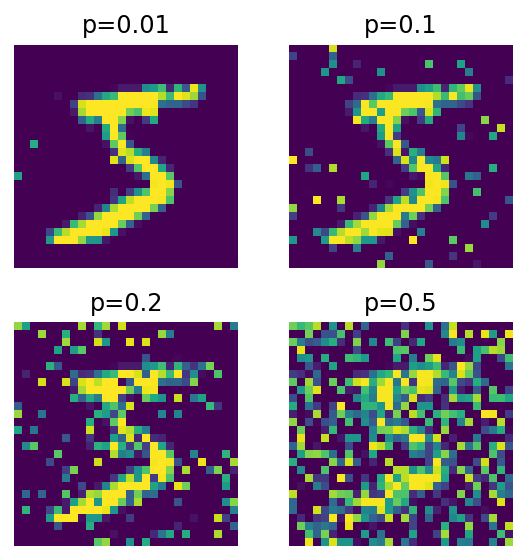

In [95]:
vals = [0.01, 0.1, 0.2, 0.5]

X_train = np.array(mnist_train.data)
y_train = np.array(mnist_train.targets)

fig, ax = plt.subplots(2, 2, figsize=(4, 4))
for axi, p in zip(ax.flat, vals):
    x_shift = Corrupt(p)(X_train[[0]]).squeeze(axis=0)
    axi.imshow(x_shift)
    axi.axis("off")
    axi.set_title(f"p={p}")
    
plt.tight_layout()

## Estimating weights

In [98]:
def make_loss_func(model, X, y):
    def loss_fn(params):
        pred = model.apply(params, X)
        loss = optax.softmax_cross_entropy(pred, y).mean()
        return loss
    return loss_fn
    # return jax.jit(loss_fn) # assuming top-levelled funciton is not jitted


class MLPWide(nn.Module):
    num_outputs: int
    @nn.compact
    def __call__(self, x):
        # x = x.reshape(-1, 1)
        x = nn.relu(nn.Dense(800)(x))
        x = nn.relu(nn.Dense(500, name="last_layer")(x))
        x = nn.Dense(self.num_outputs)(x)
        x = nn.log_softmax(x)
        return x

    
def print_progress(epoch, loss, step_mod):
    if epoch % step_mod == 0:
        print(f"Loss step ({epoch}: {loss:0.4e})")


@jax.jit
def train_step(params, opt_state, X_batch, y_batch):
    loss_fn = make_loss_func(model, X_batch, y_batch)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    
    loss_val, grads = loss_grad_fn(params)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return loss_val, params
    

def get_batch_train_ixs(key, num_samples, batch_size):
    """
    Obtain the training indices to be used in an epoch of
    mini-batch optimisation.
    """
    steps_per_epoch = num_samples // batch_size
    
    batch_ixs = jax.random.permutation(key, num_samples)
    batch_ixs = batch_ixs[:steps_per_epoch * batch_size]
    batch_ixs = batch_ixs.reshape(steps_per_epoch, batch_size)
    
    return batch_ixs


def train_epoch(key, params, opt_step, X, y, batch_size, epoch):
    num_samples = len(X)
    batch_ixs = get_batch_train_ixs(key, num_samples, batch_size)
    
    for batch_ix in batch_ixs:
        X_batch = X[batch_ix, ...]
        y_batch = y[batch_ix, ...]
        loss, params = train_step(params, opt_step, X_batch, y_batch)
    
    return params, opt_step


def proc_dataset(p, img_dataset, n_processes=90):
    """
    Rotate all images of a dataset stored in a numpy array.
    
    Parameters
    ----------
    radius: float
        Intensity of bluriness
    img_dataset: array(N, L, K)
        N images of size LxK
    n_processes: int
        Number of processes to blur over
    """
    pool = Pool(processes=n_processes)
    
    dataset_proc = np.array_split(img_dataset, n_processes)
    dataset_proc = pool.map(Corrupt(p), dataset_proc)
    dataset_proc = np.concatenate(dataset_proc, axis=0)
    
    pool.close()
    
    return dataset_proc

In [99]:
key = jax.random.PRNGKey(314)

alpha = 0.001
n_classes = 10
n_subset = 5000
batch_size = 2_000
n_epochs = 150
tx = optax.adam(learning_rate=alpha)

model = MLPWide(n_classes)
# X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
# y_train_ohe = jax.nn.one_hot(y_train, n_classes)


def train_model_config(key, deg, num_epochs):
    X_train_proc = proc_dataset(deg, X_train, 90)
    X_train_ravel = X_train_proc.reshape(-1, 28 ** 2)
    y_train_ohe = jax.nn.one_hot(y_train, n_classes)

    batch = jnp.ones((1, 28 ** 2))
    params = model.init(key, batch)
    opt_state = tx.init(params)

    for e in range(num_epochs):
        print(f"@epoch {e+1:03}", end="\r")
        _, key = jax.random.split(key)
        params, opt_state = train_epoch(key, params, opt_state, X_train_ravel, y_train_ohe, batch_size, e)

    final_train_acc = (y_train == model.apply(params, X_train_ravel).argmax(axis=1)).mean().item()
    print(f"@{deg=:0.2f}, {final_train_acc=:0.4f}")
    
    return params, final_train_acc

In [ ]:
hist_params = []
hist_accuracy = []

degrees = jnp.linspace(0, 1, 200)

time_start = time()
for deg in degrees:
    deg = deg.item()
    params, train_acc = train_model_config(key, deg, n_epochs)
    
    hist_accuracy.append(train_acc)
    hist_params.append(params)

hist_accuracy = jnp.array(hist_accuracy)
time_end = time()
time_total = time_end - time_start

print(f"Total running time: {time_total:0.2f}s")

@deg=0.00, final_train_acc=1.0000
@deg=0.01, final_train_acc=1.0000
@deg=0.01, final_train_acc=0.9999
@deg=0.02, final_train_acc=1.0000
@deg=0.02, final_train_acc=1.0000
@deg=0.03, final_train_acc=1.0000
@deg=0.03, final_train_acc=1.0000
@deg=0.04, final_train_acc=1.0000
@deg=0.04, final_train_acc=1.0000
@deg=0.05, final_train_acc=1.0000
@deg=0.05, final_train_acc=1.0000
@deg=0.06, final_train_acc=1.0000
@deg=0.06, final_train_acc=1.0000
@deg=0.07, final_train_acc=1.0000
@deg=0.07, final_train_acc=1.0000
@deg=0.08, final_train_acc=1.0000
@deg=0.08, final_train_acc=1.0000


https://symbolize.stripped_domain/r/?trace=55f894d304ea,7f57a01433bf&map= 
*** SIGTERM received by PID 12518 (TID 12518) on cpu 24 from PID 9636; stack trace: ***
PC: @     0x55f894d304ea  (unknown)  _PyFunction_Vectorcall
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=55f894d304ea,7f578f9ef7f9,7f57a01433bf&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 16:05:13.257211   12518 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 16:05:13.266554   12518 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.09, final_train_acc=1.0000
@deg=0.09, final_train_acc=1.0000
@deg=0.10, final_train_acc=1.0000
@deg=0.10, final_train_acc=1.0000
@deg=0.11, final_train_acc=1.0000


https://symbolize.stripped_domain/r/?trace=55f894d7a24b,7f57a01433bf&map= 
*** SIGTERM received by PID 13105 (TID 13105) on cpu 81 from PID 9636; stack trace: ***
PC: @     0x55f894d7a24b  (unknown)  _PyEval_EvalFrameDefault
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=55f894d7a24b,7f578f9ef7f9,7f57a01433bf&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 16:09:12.497164   13105 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 16:09:12.516153   13105 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.11, final_train_acc=1.0000
@deg=0.12, final_train_acc=1.0000
@deg=0.12, final_train_acc=1.0000
@deg=0.13, final_train_acc=1.0000
@deg=0.13, final_train_acc=1.0000
@deg=0.14, final_train_acc=1.0000
@deg=0.14, final_train_acc=1.0000
@deg=0.15, final_train_acc=1.0000
@deg=0.15, final_train_acc=1.0000
@deg=0.16, final_train_acc=0.9997
@deg=0.16, final_train_acc=1.0000
@deg=0.17, final_train_acc=1.0000
@deg=0.17, final_train_acc=1.0000
@deg=0.18, final_train_acc=0.9999
@deg=0.18, final_train_acc=1.0000
@deg=0.19, final_train_acc=0.9999
@deg=0.19, final_train_acc=0.9994


https://symbolize.stripped_domain/r/?trace=55f894d0bddb,7f57a01433bf,55f894f3711f&map=https://symbolize.stripped_domain/r/?trace=55f894d75a88,7f57a01433bf&map= 
*** SIGTERM received by PID 14794 (TID 14794) on cpu 25 from PID 9636; stack trace: ***
https://symbolize.stripped_domain/r/?trace=https://symbolize.stripped_domain/r/?trace=55f894d75a88,55f894d75a88,7f57a01433bf7f57a01433bf&map=&map=https://symbolize.stripped_domain/r/?trace=55f894cd522e,7f57a01433bf,55f894f34cff,55f894f37ebf&map= 
 
 
*** SIGTERM received by PID 14804 (TID 14804) on cpu 94 from PID 9636; stack trace: ***
 
*** SIGTERM received by PID 14796 (TID 14796) on cpu 74 from PID 9636; stack trace: ***
*** SIGTERM received by PID 14799 (TID 14799) on cpu 75 from PID 9636; stack trace: ***
*** SIGTERM received by PID 14795 (TID 14795) on cpu 36 from PID 9636; stack trace: ***
https://symbolize.stripped_domain/r/?trace=55f894d79dff,7f57a01433bf,7f566456447f,55f894f13bff&map= 
*** SIGTERM received by PID 14809 (TID 14809)

@deg=0.20, final_train_acc=1.0000
@deg=0.20, final_train_acc=1.0000
@deg=0.21, final_train_acc=0.9997
@deg=0.21, final_train_acc=0.9993
@deg=0.22, final_train_acc=0.9999
@deg=0.22, final_train_acc=0.9997
@deg=0.23, final_train_acc=0.9997
@deg=0.23, final_train_acc=0.9997
@deg=0.24, final_train_acc=0.9994
@deg=0.24, final_train_acc=0.9992
@deg=0.25, final_train_acc=0.9992
@deg=0.25, final_train_acc=0.9994
@deg=0.26, final_train_acc=0.9999
@deg=0.26, final_train_acc=0.9995


https://symbolize.stripped_domain/r/?trace=https://symbolize.stripped_domain/r/?trace=55f894ce0ac2,7f57a01433bf,55f894f3711f&map=55f894ce0ac2,7f57a01433bf,55f894f3711f 
&map= 
*** SIGTERM received by PID 16162 (TID 16162) on cpu 33 from PID 9636; stack trace: ***
*** SIGTERM received by PID 16149 (TID 16149) on cpu 26 from PID 9636; stack trace: ***
PC: @     0x55f894ce0ac2  (unknown)  PyObject_GetAttr
PC: @     0x55f894ce0ac2  (unknown)  PyObject_GetAttr
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  482111248  (unknown)
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  482111248  (unknown)
    @     0x55f894f37120  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55f894ce0ac2,7f578f9ef7f9,7f57a01433bf,55f894f3711f&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 16:33:29.217931   16149 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
    @     0x55f894f37120  (unknown)  (unknow

@deg=0.27, final_train_acc=0.9994
@deg=0.27, final_train_acc=0.9991
@deg=0.28, final_train_acc=0.9996
@deg=0.28, final_train_acc=0.9987
@deg=0.29, final_train_acc=0.9983
@deg=0.29, final_train_acc=0.9978
@deg=0.30, final_train_acc=0.9995
@deg=0.30, final_train_acc=0.9981
@deg=0.31, final_train_acc=0.9952


https://symbolize.stripped_domain/r/?trace=55f894d78e39,7f57a01433bf,7f56646e603f,55f894f40a3f&map= 
*** SIGTERM received by PID 17078 (TID 17078) on cpu 28 from PID 9636; stack trace: ***
PC: @     0x55f894d78e39  (unknown)  _PyEval_EvalFrameDefault
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @     0x7f56646e6040  (unknown)  (unknown)
    @     0x55f894f40a40  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55f894d78e39,7f578f9ef7f9,7f57a01433bf,7f56646e603f,55f894f40a3f&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 16:40:42.483615   17078 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 16:40:42.510886   17078 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.31, final_train_acc=0.9996
@deg=0.32, final_train_acc=0.9863
@deg=0.32, final_train_acc=0.9882
@deg=0.33, final_train_acc=0.9866
@deg=0.33, final_train_acc=0.9934
@deg=0.34, final_train_acc=0.9888
@deg=0.34, final_train_acc=0.9905
@deg=0.35, final_train_acc=0.9827
@deg=0.35, final_train_acc=0.9802
@deg=0.36, final_train_acc=0.9753
@deg=0.36, final_train_acc=0.9721
@deg=0.37, final_train_acc=0.9769
@deg=0.37, final_train_acc=0.9801
@deg=0.38, final_train_acc=0.9689
@deg=0.38, final_train_acc=0.9664
@deg=0.39, final_train_acc=0.9596
@deg=0.39, final_train_acc=0.9667
@deg=0.40, final_train_acc=0.9670
@deg=0.40, final_train_acc=0.9546
@deg=0.41, final_train_acc=0.9489
@deg=0.41, final_train_acc=0.9604
@deg=0.42, final_train_acc=0.9492
@deg=0.42, final_train_acc=0.9395
@deg=0.43, final_train_acc=0.9451
@deg=0.43, final_train_acc=0.9392
@deg=0.44, final_train_acc=0.9321
@deg=0.44, final_train_acc=0.9468
@deg=0.45, final_train_acc=0.9378
@deg=0.45, final_train_acc=0.9485
@deg=0.46, fin

https://symbolize.stripped_domain/r/?trace=7f57a0141a65,7f57a01433bf&map= 
*** SIGTERM received by PID 20701 (TID 20701) on cpu 1 from PID 9636; stack trace: ***
PC: @     0x7f57a0141a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f57a0141a65,7f578f9ef7f9,7f57a01433bf&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:08:48.447794   20701 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
https://symbolize.stripped_domain/r/?trace=7f57a0141a65,7f57a01433bf&map= 
*** SIGTERM received by PID 20704 (TID 20704) on cpu 50 from PID 9636; stack trace: ***
PC: @     0x7f57a0141a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f57

@deg=0.49, final_train_acc=0.9044
@deg=0.49, final_train_acc=0.9168
@deg=0.50, final_train_acc=0.8722


https://symbolize.stripped_domain/r/?trace=7f57a0141a65,7f57a01433bf&map= 
*** SIGTERM received by PID 21000 (TID 21000) on cpu 22 from PID 9636; stack trace: ***
PC: @     0x7f57a0141a65  (unknown)  sem_post@@GLIBC_2.2.5
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=7f57a0141a65,7f578f9ef7f9,7f57a01433bf&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:11:13.536979   21000 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 17:11:13.551733   21000 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.50, final_train_acc=0.9244
@deg=0.51, final_train_acc=0.8940
@deg=0.51, final_train_acc=0.9008
@deg=0.52, final_train_acc=0.8803
@deg=0.52, final_train_acc=0.9070
@deg=0.53, final_train_acc=0.8866
@deg=0.53, final_train_acc=0.8824


https://symbolize.stripped_domain/r/?trace=55f894d705da,7f57a01433bf,55f894f2ef5f&map= 
*** SIGTERM received by PID 21631 (TID 21631) on cpu 4 from PID 9636; stack trace: ***
PC: @     0x55f894d705da  (unknown)  PyObject_SetAttr
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  480201024  (unknown)
    @     0x55f894f2ef60  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55f894d705da,7f578f9ef7f9,7f57a01433bf,55f894f2ef5f&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:16:54.745191   21631 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 17:16:54.769245   21631 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.54, final_train_acc=0.8895
@deg=0.54, final_train_acc=0.8816
@deg=0.55, final_train_acc=0.8388
@deg=0.55, final_train_acc=0.8701
@deg=0.56, final_train_acc=0.8754
@deg=0.56, final_train_acc=0.8620
@deg=0.57, final_train_acc=0.7219


https://symbolize.stripped_domain/r/?trace=55f894d0bddb,7f57a01433bf,55f894f3711f&map= 
*** SIGTERM received by PID 22343 (TID 22343) on cpu 67 from PID 9636; stack trace: ***
PC: @     0x55f894d0bddb  (unknown)  insertdict
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  472555600  (unknown)
    @     0x55f894f37120  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55f894d0bddb,7f578f9ef7f9,7f57a01433bf,55f894f3711f&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:22:35.762472   22343 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 17:22:35.789346   22343 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.57, final_train_acc=0.8587
@deg=0.58, final_train_acc=0.8572
@deg=0.58, final_train_acc=0.8504
@deg=0.59, final_train_acc=0.8496


https://symbolize.stripped_domain/r/?trace=55f894ceb569,7f57a01433bf,7f579fa0a12f&map= 
*** SIGTERM received by PID 22815 (TID 22815) on cpu 88 from PID 9636; stack trace: ***
PC: @     0x55f894ceb569  (unknown)  _PyType_Lookup
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @     0x7f579fa0a130  (unknown)  (unknown)
https://symbolize.stripped_domain/r/?trace=55f894ceb569,7f578f9ef7f9,7f57a01433bf,7f579fa0a12f&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:25:49.892186   22815 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 17:25:49.928299   22815 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.59, final_train_acc=0.8523
@deg=0.60, final_train_acc=0.8259


https://symbolize.stripped_domain/r/?trace=55f894d30ac1,7f57a01433bf&map= 
*** SIGTERM received by PID 23032 (TID 23032) on cpu 54 from PID 9636; stack trace: ***
PC: @     0x55f894d30ac1  (unknown)  _PyFunction_Vectorcall
    @     0x7f578f9ef7fa        992  (unknown)
    @     0x7f57a01433c0  (unknown)  (unknown)
    @ ... and at least 1 more frames
https://symbolize.stripped_domain/r/?trace=55f894d30ac1,7f578f9ef7f9,7f57a01433bf&map=7a511a57244151c993b16b37978e7ed7:7f5781017000-7f578fd59d50 
E0217 17:27:27.790011   23032 coredump_hook.cc:320] RAW: Remote crash gathering disabled for SIGTERM.
E0217 17:27:27.805101   23032 process_state.cc:770] RAW: Raising signal 15 with default behavior


@deg=0.60, final_train_acc=0.8419


In [ ]:
hist_params_flat = dojax.flat_and_concat_params(hist_params)
jnp.save("mnist_corrupt_params.npy", hist_params_flat)

In [138]:
proj = PCA(n_components=2)
# proj = TSNE(n_components=2, init="pca", random_state=314,
#             perplexity=30, learning_rate="auto")
params_proj = proj.fit_transform(hist_params_flat)

Text(0, 0.5, 'Accuracy')

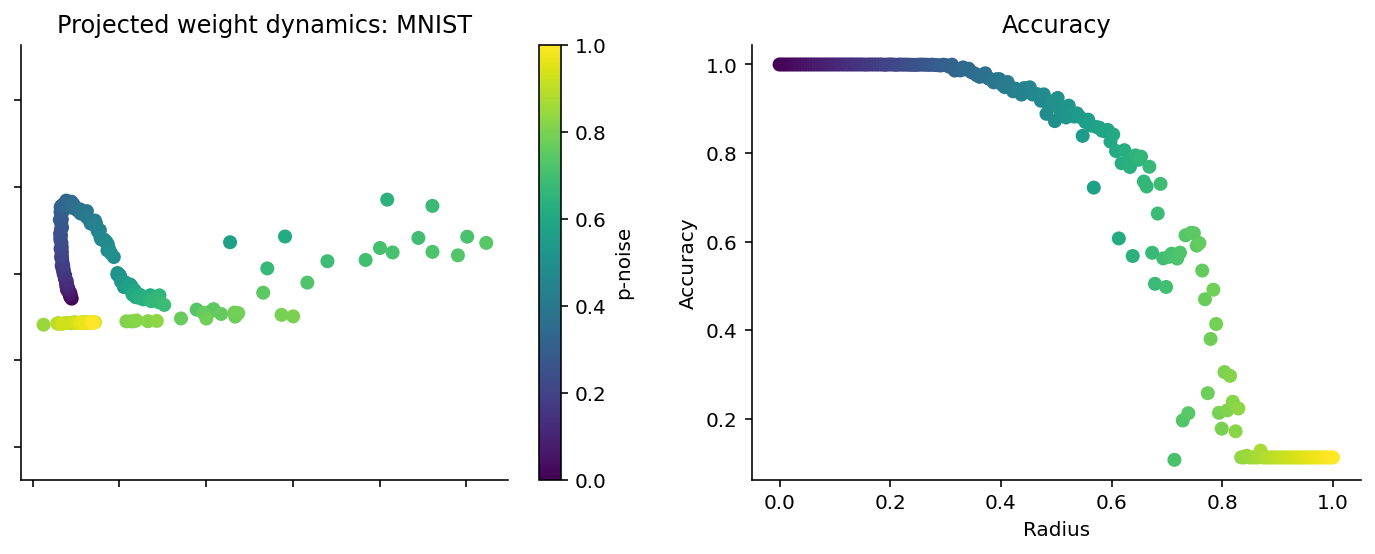

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Projected weight dynamics: MNIST")
p = ax[0].scatter(*params_proj.T, c=degrees)
fig.colorbar(p, ax=ax[0], label="p-noise")
ax[0].tick_params(axis="both", labelleft=False, labelbottom=False)
ax[0].axis("equal")

ax[1].set_title("Accuracy")
ax[1].scatter(degrees, hist_accuracy, c=degrees)
ax[1].set_xlabel("Radius")
ax[1].set_ylabel("Accuracy")